# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    else:
        return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    else:
        return 0.5 * np.mean((y - y_pred) ** 2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y * np.log(y_sigmoid) + (1 - y) * np.log(1 - y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [7]:
#não utilizar metodos de inicializar com apenas zeros e uns para não ter uma rede simetrica
def zeros(rows, columns):
    return np.zeros((rows, columns))

def ones(rows, columns):
    return np.ones((rows, columns))

#normal aleatoria
def random_normal(rows, columns):
    return np.random.randn(rows, columns)

#uniforme aletaria
def random_uniform(rows, columns):
    return np.random.rand(rows, columns)

#glorot uniforme quebra a simetria e converge mais rapidamente sqrt(6/(in + out))
def glorot_uniform(rows, columns):
    limit = np.sqrt(6/(rows + columns))
    return 2*limit * np.random.rand(rows, columns) - limit

#glorot normal quebra a simetria e converge mais rapidamente sqrt(2/(in + out))
def glorot_normal(rows, columns):
    std_dev = np.sqrt(2/(rows + columns))
    return std_dev * np.random.randn(rows, columns)

# Regularização

In [8]:
#regularização L1 mata alguns neoronios, faz seleção de atributos importantes, dificil de estimar aplique apenas em casos de overfitting 
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

#regularização L2 nenhum atributo é mais importante, tende a diminui e espelaha valores e decaimento dos pesos, dificil de estimar aplique apenas em overfitting
def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [9]:
#Mini-batch divide o conjunto de treinamento em conjuntos menores, é importante dar shuffle (embaralhar) antes de cada epoch = processar todos os batch em geral é 
# a estratégia de gradiente descendente mais utilizada
#gradiente estocastico aprende com apenass uma amostra por vez, gradiente para cada amostra, conversão lenta, anula vetorização
#mini-batch Em geral aponta para direção que desce, converge rapido, mas não tão rapido como batch, rapida execução
#batch gradiente aponta para direção que sempre desce, converge rapido, execução lenta

def batch_sequential(x, y, batch_size = None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batchs = x.shape[0] // batch_size
    for batch in range(n_batchs):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield(x_batch,y_batch)


def batch_shuffle(x, y, batch_size = None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [10]:
#learning rate influencia diretamente a aprendizagem da rede, valores altos e baixos, busca decair a learning rate ao longo do tempo
#time based menor o alpha menor a aprendizagem
def none_decay(learnin_rate, epoch, decay_rate, decay_steps = 1):
    return learnin_rate

def time_based_decay(learnin_rate, epoch, decay_rate, decay_steps = 1):
    return 1 / (1 + decay_rate * epoch)

#exponencial maior o alpha menor aprendizagem
def exponential_decay(learnin_rate, epoch, decay_rate, decay_steps = 1):
    return learnin_rate * decay_rate ** epoch

#stair case decaimento controlado por epochs
def staircase_decay(learnin_rate, epoch, decay_rate, decay_steps = 1):
    return learnin_rate * decay_rate ** (epoch // decay_steps)

# Batch Normalization 

In [11]:
#normaliza entradas ou saidas das funções de ativação estima media e desvio padrão baseada no batch média movel reguariza camadas, pode substituir a dropout cuidado na validação 
# e teste cuidado no gradient checking  

# x_mu = x- mu
# var = (1/m) * np.sum(x_mu**2)
# std_inv = 1 / np.sqrt(var)
# x_norm = x_mu * std_inv
# out = gamma * x_norm + beta

# d_out = 1
# d_gamma = x_norm * d_out
# d_x_norm = gamma * d_out
# d_beta = 1 * d_out

# d_x_mu = std_inv * d_x_norm
# d_std_inv = x_mu * d_x_norm

# d_var = -0.5 * (var ** (-3/2)) * d_std_inv
# d_x_mu += (1/m) * 2 * x_mu *d_var
# dx = 1 * d_x_mu
# d_mu = -1 * d_x_mu
# dx += (1/m) * d_mu 

def batchnorm_forward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta

    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0-layer.bn_decay)*mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0-layer.bn_decay)*var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache

    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1. / np.sqrt(var + 1e-8)

    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv**3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)

    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    return dx

#freezing congela pesos de certas camadas de conhecimento, muito utilizada para transferencia de conhecimento e fine-tuning aplique apenas em redes pre treinadas

# Gradient Cheking

In [179]:
def  __compute_aproxx_grads(nn, x, y, eps = 1e-4):
    #criando lista para receber os gradientes aproximados
    approx_grads = []

    #simulando a feedfoward pa um unico peso
    feed_foward = lambda inp: nn._NeuralNetwork__feed_forward(inp, is_training=True)

    # Para cada camada da rede neural
    for layer in nn.layers:
        assert(layer.dropout_prob == 0), 'O Gradient Cheking não pode ser aplicado em redes com DROPOUT'
        # Copiando os pesos 
        w_ori = layer.weights.copy()
        
        # Transformando os pesos em listas
        w_ravel = w_ori.ravel()

        # Pegando as dimensões originais da matriz de pesos
        w_shape = w_ori.shape

        # Para cada peso na lista de pesos
        for i in range(w_ravel.size):
            
            # Copiar peso 
            w_plus = w_ravel.copy()

            # Adicionando o valor de h aos pesos
            w_plus[i] += eps

            # Remontando a estrutura de pesos
            layer.weights = w_plus.reshape(w_shape)

            # Calculando custo
            j_plus = nn.cost_function(y, feed_foward(x)) + (1.0/y.shape[0]) * (layer.reg_strength * layer.reg_func(layer.weights))

            # Copiar peso 
            w_minus = w_ravel.copy()
            
            # Subtraindo o valor de h aos pesos
            w_minus[i] -= eps

            # Remontando a estrutura de pesos
            layer.weights = w_minus.reshape(w_shape)

            # Calculando custo
            j_minus = nn.cost_function(y, feed_foward(x)) + (1.0/y.shape[0]) * (layer.reg_strength * layer.reg_func(layer.weights))

            # Calculando o gradiente aproximado e adicionando à lista de gradientes
            approx_grads.append((j_plus - j_minus) / (2 * eps))

        # Redefinindo os pesos para os pesos originais
        layer.weights = w_ori

    # Retornando lista de gradientes
    return approx_grads


def gradient_checking(nn, x, y, eps=1e-4, verbose=False, verbose_precision = 5):
    from copy import deepcopy

    #copiando rede neural
    nn_copy = deepcopy(nn)

    #calculando os gradientes das camadas
    nn.fit(x, y, epochs = 0)
    grads = np.concatenate([layer._dweights.ravel() for layer in nn.layers])

    #calculando os gradientes aproximados 
    approx_grads = __compute_aproxx_grads(nn_copy, x, y, eps)

    #verificando se os gradientes aproximados estão proximos dos gradientes calculados pela rede
    is_close = np.allclose(grads, approx_grads)
    print('\033[92m GRADIENTS OK' if is_close else '\033[91m GRADIENTS FAIL')

    #calculando erro relativo
    norm_num = np.linalg.norm(grads - approx_grads)
    norm_den = np.linalg.norm(grads) + np.linalg.norm(approx_grads)
    erro = norm_num/norm_den
    print(f'Relative error: {erro}')

    if verbose:
        np.set_printoptions(precision=verbose_precision, linewidth=200, suppress=True)
        print(f'Gradientes: {grads}')
        print(f'Aproximado: {np.array(approx_grads)}')

# Implementação 

In [25]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, dropout_prob=0, reg_func=l2_regularization, reg_strength=0, batch_norm = False, bn_decay =0.9, is_trainable = True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1,output_dim), zeros(1,output_dim)
        self.is_trainable = is_trainable

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method = none_decay, lr_decay_rate = 0, lr_decay_steps = 1,momentum=0, patience = np.inf):
        self.layers = []
        self.cost_function = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf

    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)

        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)

            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feed_forward(x_batch)
                self.__back_propagation(y_batch, y_pred)

            loss_val = self.cost_function(y_val, self.predict(x_val))
            if loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, loss_val
                self.waiting = 0
            else:
                self.waiting += 1
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    return
            
            if epoch % verbose == 0:
                loss_train = self.cost_function(y_train, self.predict(x_train))
                loss_reg = (1.0/y_train.shape[0])*np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in self.layers])
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch, epochs, loss_train, loss_reg, loss_train + loss_reg, loss_val))

    def predict(self, x):
        return self.__feed_forward(x,is_training = False)
    
    def save(self, file_path):
        pkl.dump(self, open(file_path, 'wb'), -1)

    def load(file_path):
        return pkl.load(open(file_path, 'rb'))

    def __feed_forward(self, x, is_training = True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:]+[Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1 - current_layer.dropout_prob, y.shape) / (1 - current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __back_propagation(self, y, y_pred):
        last_delta = self.cost_function(y, y_pred, derivative = True)
        for layer in reversed(self.layers):
            d_activation = layer.activation(layer._activ_inp, derivative = True) * last_delta * layer._dropout_mask
            d_activation = batchnorm_backward(layer, d_activation) if layer.batch_norm else d_activation
            last_delta = np.dot(d_activation, layer.weights)
            layer._dweights = np.dot(d_activation.T, layer.input)
            layer._dbiases = 1.0 * d_activation.sum(axis=0, keepdims=True)

        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0/y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative=True)
                layer._prev_dweights = -self.learning_rate * layer._dweights + self.momentum * layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate * layer._dbiases
                
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate * layer._dgamma
                    layer.beta = layer.beta - self.learning_rate * layer._dbeta

In [14]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

x, y = make_regression(n_samples=100, n_features=1, n_informative=2, noise=10, random_state=42)
x, y = x.reshape(-1,1), y.reshape(-1,1)
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.3, random_state=42)

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1, patience=10)
nn.layers.append(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=linear))

nn.fit(x_train, y_train, x_val = x_test, y_val = y_test, epochs=1000, verbose=50)

epoch:    0/1000 loss_train: 757.21365432 + 0.00000000 = 757.21365432 loss_val = 796.81470495
epoch:   50/1000 loss_train: 35.46760251 + 0.00000000 = 35.46760251 loss_val = 53.42887294
epoch:  100/1000 loss_train: 35.23225578 + 0.00000000 = 35.23225578 loss_val = 51.77303739
epoch:  150/1000 loss_train: 35.23214680 + 0.00000000 = 35.23214680 loss_val = 51.73732024
epoch:  200/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73653094
epoch:  250/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651380
epoch:  300/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651343
epoch:  350/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342
epoch:  400/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342
epoch:  450/1000 loss_train: 35.23214675 + 0.00000000 = 35.23214675 loss_val = 51.73651342


## Exemplos do Notebook da Intuição

### Exemplo 1

In [44]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# insira sua rede aqui!
input_dim, output_dim = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
input_dim, output_dim = x.shape[1], y.shape[1]
nn.layers.append(Layer(input_dim = input_dim, output_dim = 2, activation=sigmoid))
nn.layers.append(Layer(input_dim = 2, output_dim = output_dim, activation=sigmoid))

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

nn.save('model.pkl')

epoch:    0/0 loss_train: 0.14023572 + 0.00000000 = 0.14023572 loss_val = 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


In [13]:
nn = NeuralNetwork.load('model.pkl')
for layer in nn.layers:
    print(layer.weights)

[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [34]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
input_dim, output_dim = x.shape[1], y.shape[1]
nn.layers.append(Layer(input_dim = D_in, output_dim = 3, activation=relu))
nn.layers.append(Layer(input_dim = 3, output_dim = 3, activation=sigmoid))
nn.layers.append(Layer(input_dim = 3, output_dim = D_out, activation=linear))

for i,w,b in zip(range(3), [w1,w2,w3], [b1,b2,b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b


nn.fit(x, y, epochs=300, verbose=30)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss_train: 1.14054966
epoch:   30/300 loss_train: 0.59630022
epoch:   60/300 loss_train: 0.36031189
epoch:   90/300 loss_train: 0.24668884
epoch:  120/300 loss_train: 0.18386202
epoch:  150/300 loss_train: 0.14510157
epoch:  180/300 loss_train: 0.11918285
epoch:  210/300 loss_train: 0.10078511
epoch:  240/300 loss_train: 0.08712037
epoch:  270/300 loss_train: 0.07660623
epoch:  300/300 loss_train: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.20173942 0.70608796]
 [0.40145052 0.30290104 0.91015363]]
[[0.20544723 0.30673159 0.50749567]
 [0.30994562 0.5123005  0.71366784]
 [0.61065514 0.41317913 0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Gradient Checking

In [180]:
np.random.seed(1234)

N, D = 100, 2

x = np.random.rand(N, D)

In [191]:
#modelo de regreção linear

y = np.random.rand(N, 1)

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9, lr_decay_method=staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=x.shape[1], output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization, reg_strength=1, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, batch_norm=True, reg_func=l1_regularization, reg_strength=1e-3))
nn.layers.append(Layer(input_dim=3, output_dim=y.shape[1], activation=linear, batch_norm=True, reg_func=l2_regularization, reg_strength=1e-3))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 869.68679072 + 0.04617212 = 869.73296284 loss_val = 869.68679072
epoch:   10/100 loss_train: 0.04436360 + 0.04614964 = 0.09051324 loss_val = 0.04436360
epoch:   20/100 loss_train: 0.84780703 + 0.04612223 = 0.89392926 loss_val = 0.84780703
epoch:   30/100 loss_train: 0.72704435 + 0.04610291 = 0.77314726 loss_val = 0.72704435
epoch:   40/100 loss_train: 0.68354139 + 0.04609127 = 0.72963267 loss_val = 0.68354139
epoch:   50/100 loss_train: 0.67215009 + 0.04608474 = 0.71823483 loss_val = 0.67215009
epoch:   60/100 loss_train: 0.66362547 + 0.04608123 = 0.70970669 loss_val = 0.66362547
epoch:   70/100 loss_train: 0.65980280 + 0.04607938 = 0.70588218 loss_val = 0.65980280
epoch:   80/100 loss_train: 0.65810723 + 0.04607842 = 0.70418565 loss_val = 0.65810723
epoch:   90/100 loss_train: 0.65731775 + 0.04607793 = 0.70339568 loss_val = 0.65731775
epoch:  100/100 loss_train: 0.65693429 + 0.04607768 = 0.70301197 loss_val = 0.65693429
epoch:    0/0 loss_train: 0.65603906 

In [216]:


y = np.random.randint(0,2, (N,1))

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-3, momentum=0.9, lr_decay_method=staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=x.shape[1], output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization, reg_strength=1, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, batch_norm=True, reg_func=l1_regularization, reg_strength=1e-3))
nn.layers.append(Layer(input_dim=3, output_dim=y.shape[1], activation=sigmoid, batch_norm=True, reg_func=l2_regularization, reg_strength=1e-3))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 12.33106545 + 0.04514481 = 12.37621026 loss_val = 12.33106545
epoch:   10/100 loss_train: 1.36334606 + 0.04511823 = 1.40846429 loss_val = 1.36334606
epoch:   20/100 loss_train: 0.94954538 + 0.04508550 = 0.99463088 loss_val = 0.94954538
epoch:   30/100 loss_train: 0.85491951 + 0.04506240 = 0.89998190 loss_val = 0.85491951
epoch:   40/100 loss_train: 0.83039584 + 0.04504849 = 0.87544433 loss_val = 0.83039584
epoch:   50/100 loss_train: 0.82253250 + 0.04504071 = 0.86757321 loss_val = 0.82253250
epoch:   60/100 loss_train: 0.81971419 + 0.04503653 = 0.86475071 loss_val = 0.81971419
epoch:   70/100 loss_train: 0.81870639 + 0.04503433 = 0.86374072 loss_val = 0.81870639
epoch:   80/100 loss_train: 0.81833377 + 0.04503320 = 0.86336697 loss_val = 0.81833377
epoch:   90/100 loss_train: 0.81819169 + 0.04503262 = 0.86322431 loss_val = 0.81819169
epoch:  100/100 loss_train: 0.81813586 + 0.04503233 = 0.86316818 loss_val = 0.81813586
epoch:    0/0 loss_train: 0.81810606 + 0

In [259]:
y = np.random.randint(0,10, (N, 1))

y_oh = OneHotEncoder(sparse_output=False).fit_transform(y)

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-3, momentum=0.9, lr_decay_method=staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=x.shape[1], output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization, reg_strength=1, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, batch_norm=True, reg_func=l1_regularization, reg_strength=1e-3))
nn.layers.append(Layer(input_dim=3, output_dim=y_oh.shape[1], activation=linear, batch_norm=True, reg_func=l2_regularization, reg_strength=1e-3))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y_oh, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 195.07007319 + 0.03473126 = 195.10480445 loss_val = 195.07007319
epoch:   10/100 loss_train: 13.52321020 + 0.03470613 = 13.55791634 loss_val = 13.52321020
epoch:   20/100 loss_train: 6.23494405 + 0.03468993 = 6.26963399 loss_val = 6.23494405
epoch:   30/100 loss_train: 3.89611316 + 0.03468051 = 3.93079366 loss_val = 3.89611316
epoch:   40/100 loss_train: 2.90961753 + 0.03467160 = 2.94428912 loss_val = 2.90961753
epoch:   50/100 loss_train: 2.70388763 + 0.03466527 = 2.73855290 loss_val = 2.70388763
epoch:   60/100 loss_train: 2.69986996 + 0.03466162 = 2.73453158 loss_val = 2.69986996
epoch:   70/100 loss_train: 2.70632700 + 0.03465960 = 2.74098659 loss_val = 2.70632700
epoch:   80/100 loss_train: 2.70924668 + 0.03465848 = 2.74390517 loss_val = 2.70924668
epoch:   90/100 loss_train: 2.71036630 + 0.03465788 = 2.74502418 loss_val = 2.71036630
epoch:  100/100 loss_train: 2.71081028 + 0.03465756 = 2.74546784 loss_val = 2.71081028
epoch:    0/0 loss_train: 2.909670

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


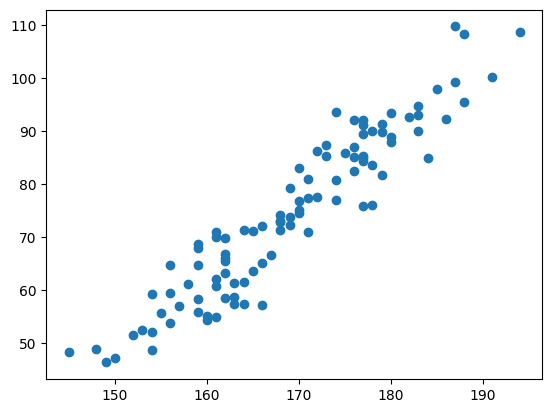

In [35]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


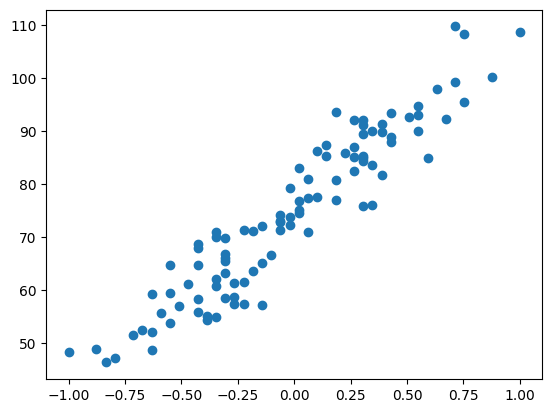

In [36]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())
plt.scatter(x, y)

epoch:    0/1000 loss_train: 2287.70290297
epoch:  100/1000 loss_train: 15.51041793
epoch:  200/1000 loss_train: 13.09817367
epoch:  300/1000 loss_train: 13.04276012
epoch:  400/1000 loss_train: 13.04148717
epoch:  500/1000 loss_train: 13.04145793
epoch:  600/1000 loss_train: 13.04145726
epoch:  700/1000 loss_train: 13.04145724
epoch:  800/1000 loss_train: 13.04145724
epoch:  900/1000 loss_train: 13.04145724
epoch: 1000/1000 loss_train: 13.04145724
[[33.60164745]]
[[74.99636286]]


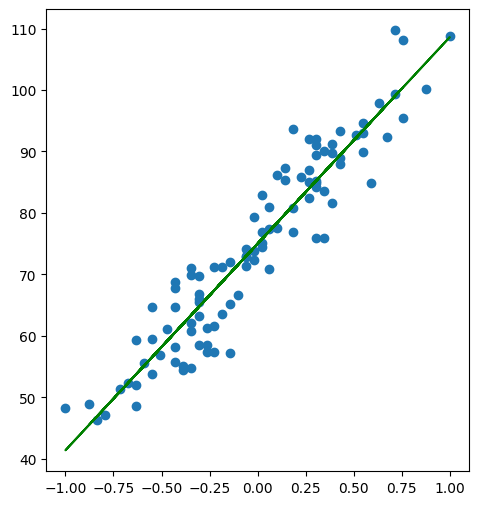

In [37]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim, output_dim, linear))

nn.fit(x,y,1000,100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [38]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [39]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [40]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim, output_dim, activation=linear))
nn.fit(x, y, 20000, 1000)
print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/20000 loss_train: 10030.60910832
epoch: 1000/20000 loss_train: 2.91188474
epoch: 2000/20000 loss_train: 2.86951994
epoch: 3000/20000 loss_train: 2.86891398
epoch: 4000/20000 loss_train: 2.86890375
epoch: 5000/20000 loss_train: 2.86890358
epoch: 6000/20000 loss_train: 2.86890357
epoch: 7000/20000 loss_train: 2.86890357
epoch: 8000/20000 loss_train: 2.86890357
epoch: 9000/20000 loss_train: 2.86890357
epoch: 10000/20000 loss_train: 2.86890357
epoch: 11000/20000 loss_train: 2.86890357
epoch: 12000/20000 loss_train: 2.86890357
epoch: 13000/20000 loss_train: 2.86890357
epoch: 14000/20000 loss_train: 2.86890357
epoch: 15000/20000 loss_train: 2.86890357
epoch: 16000/20000 loss_train: 2.86890357
epoch: 17000/20000 loss_train: 2.86890357
epoch: 18000/20000 loss_train: 2.86890357
epoch: 19000/20000 loss_train: 2.86890357
epoch: 20000/20000 loss_train: 2.86890357
[[ 8.72048636 14.1054877  26.26749487]]
[[150.65175754]]


### Regressão Quadrática

(100, 1) (100, 1)


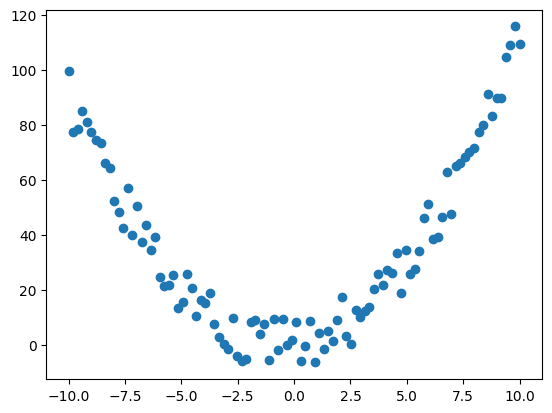

In [111]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [112]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000000 loss_train: 1087.10365728
epoch: 100000/1000000 loss_train: 12.53908202
epoch: 200000/1000000 loss_train: 11.68301065
epoch: 300000/1000000 loss_train: 11.45214697
epoch: 400000/1000000 loss_train: 11.36760735
epoch: 500000/1000000 loss_train: 11.32485860
epoch: 600000/1000000 loss_train: 11.29817229
epoch: 700000/1000000 loss_train: 11.27240220
epoch: 800000/1000000 loss_train: 11.07590025
epoch: 900000/1000000 loss_train: 10.80684803
epoch: 1000000/1000000 loss_train: 10.69374219


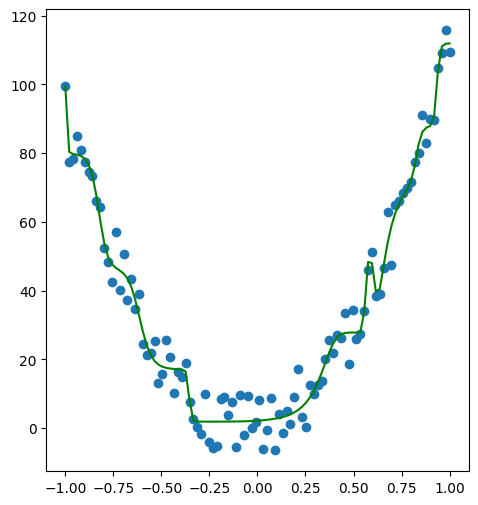

In [114]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=input_dim, output_dim=30, activation=sigmoid, weights_initializer=random_uniform))
nn.layers.append(Layer(input_dim=30, output_dim=20, activation=sigmoid, weights_initializer=glorot_normal, biases_initializer=random_uniform))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear, weights_initializer=glorot_uniform))

nn.fit(x, y, 1000000, 100000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')#4.43

### Regressão Cúbica

(100, 1) (100, 1)


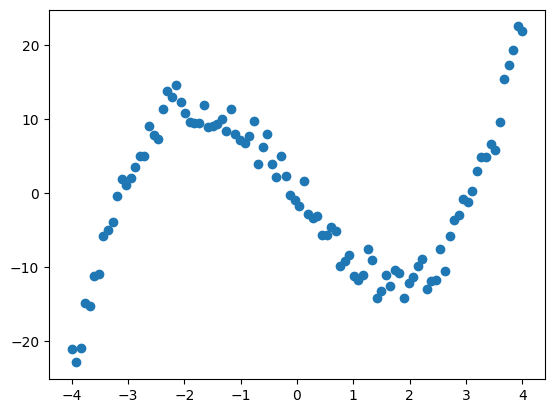

In [44]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [45]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000000 loss_train: 47.46303866
epoch: 100000/1000000 loss_train: 0.70053182
epoch: 200000/1000000 loss_train: 0.54200416
epoch: 300000/1000000 loss_train: 0.52179387
epoch: 400000/1000000 loss_train: 0.51475957
epoch: 500000/1000000 loss_train: 0.50590978
epoch: 600000/1000000 loss_train: 0.50596019
epoch: 700000/1000000 loss_train: 0.44741440
epoch: 800000/1000000 loss_train: 0.42927638
epoch: 900000/1000000 loss_train: 0.42378824
epoch: 1000000/1000000 loss_train: 0.41379132


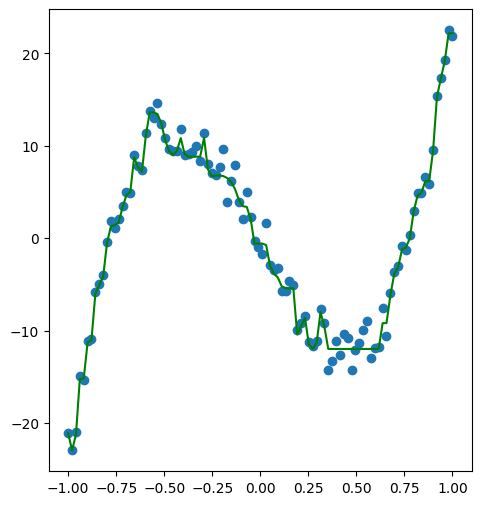

In [46]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=30, activation=tanh))
nn.layers.append(Layer(input_dim=30, output_dim=20, activation=tanh, dropout_prob=0))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))
nn.fit(x, y, 1000000, 100000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


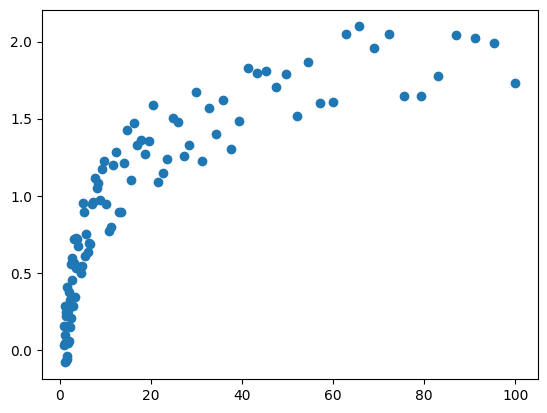

In [47]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [48]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000000 loss_train: 3.41681673
epoch: 100000/1000000 loss_train: 0.01223129
epoch: 200000/1000000 loss_train: 0.01148373
epoch: 300000/1000000 loss_train: 0.01141093
epoch: 400000/1000000 loss_train: 0.01138635
epoch: 500000/1000000 loss_train: 0.01137225
epoch: 600000/1000000 loss_train: 0.01136093
epoch: 700000/1000000 loss_train: 0.01135051
epoch: 800000/1000000 loss_train: 0.01134029
epoch: 900000/1000000 loss_train: 0.01133014
epoch: 1000000/1000000 loss_train: 0.01132005


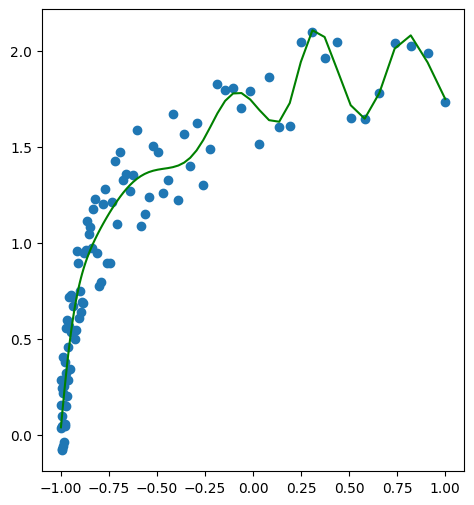

In [49]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=30, activation=tanh))
nn.layers.append(Layer(input_dim=30, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))
nn.fit(x, y, 1000000, 100000)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


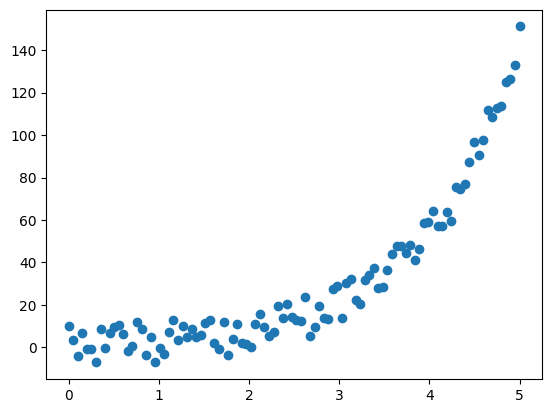

In [50]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [51]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000000 loss_train: 367.20088746
epoch: 100000/1000000 loss_train: 14.71499755
epoch: 200000/1000000 loss_train: 14.56002183
epoch: 300000/1000000 loss_train: 14.14220971
epoch: 400000/1000000 loss_train: 13.49482751
epoch: 500000/1000000 loss_train: 13.17306136
epoch: 600000/1000000 loss_train: 13.05997436
epoch: 700000/1000000 loss_train: 12.97761158
epoch: 800000/1000000 loss_train: 12.92747518
epoch: 900000/1000000 loss_train: 12.94114703
epoch: 1000000/1000000 loss_train: 13.05488929


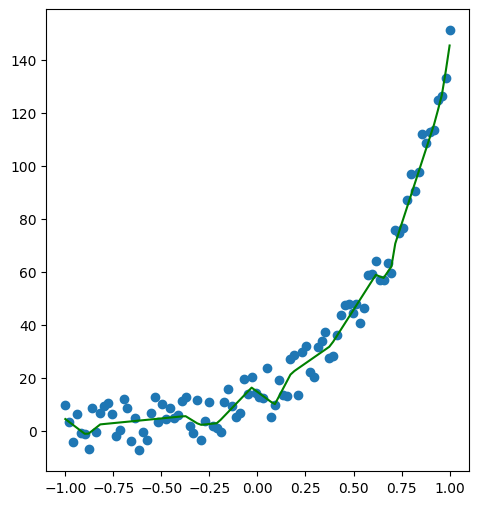

In [52]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=leaky_relu))
nn.layers.append(Layer(input_dim=20, output_dim=25, activation=leaky_relu))
nn.layers.append(Layer(input_dim=25, output_dim=output_dim, activation=linear))
nn.fit(x, y, 1000000, 100000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


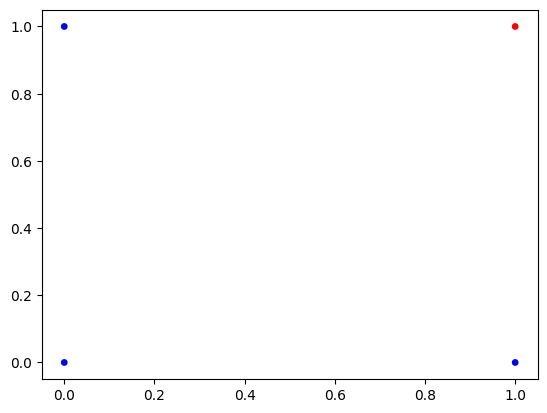

In [53]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.93749538
epoch:  100/1000 loss_train: 0.15017187
epoch:  200/1000 loss_train: 0.08374524
epoch:  300/1000 loss_train: 0.05754230
epoch:  400/1000 loss_train: 0.04363448
epoch:  500/1000 loss_train: 0.03505984
epoch:  600/1000 loss_train: 0.02926284
epoch:  700/1000 loss_train: 0.02509012
epoch:  800/1000 loss_train: 0.02194690
epoch:  900/1000 loss_train: 0.01949615
epoch: 1000/1000 loss_train: 0.01753296
Predições:
[[1.27051043e-05]
 [2.03737733e-02]
 [2.03737633e-02]
 [9.71464290e-01]]
Acurácia: 100.00%


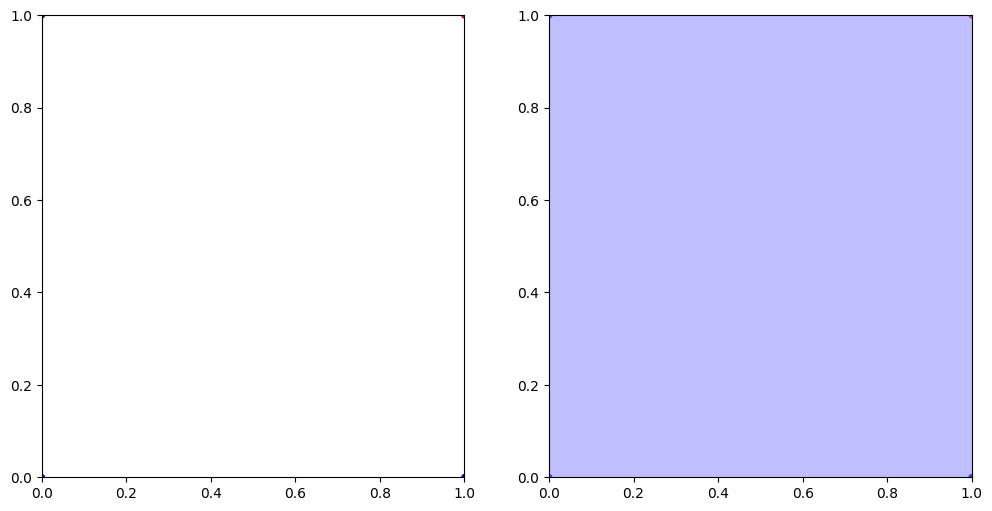

In [54]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(binary_cross_entropy, learning_rate=1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, 1000,100)

y_pred = nn.predict(x)

print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


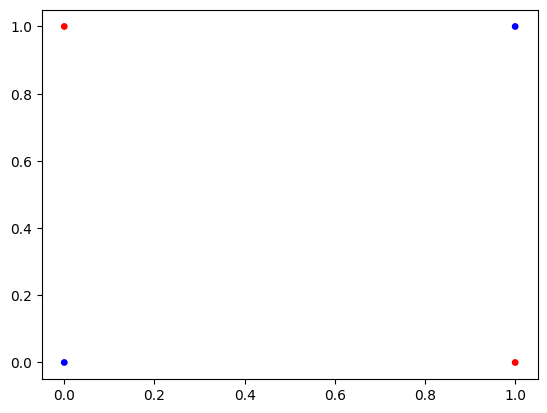

In [55]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.70671979
epoch:  100/1000 loss_train: 0.63568407
epoch:  200/1000 loss_train: 0.49460434
epoch:  300/1000 loss_train: 0.23541341
epoch:  400/1000 loss_train: 0.07526382
epoch:  500/1000 loss_train: 0.04008257
epoch:  600/1000 loss_train: 0.02697172
epoch:  700/1000 loss_train: 0.02027942
epoch:  800/1000 loss_train: 0.01624095
epoch:  900/1000 loss_train: 0.01354327
epoch: 1000/1000 loss_train: 0.01161474
Predições:
[[0.00537533]
 [0.98929917]
 [0.98714916]
 [0.01722642]]
Acurácia: 100.00%


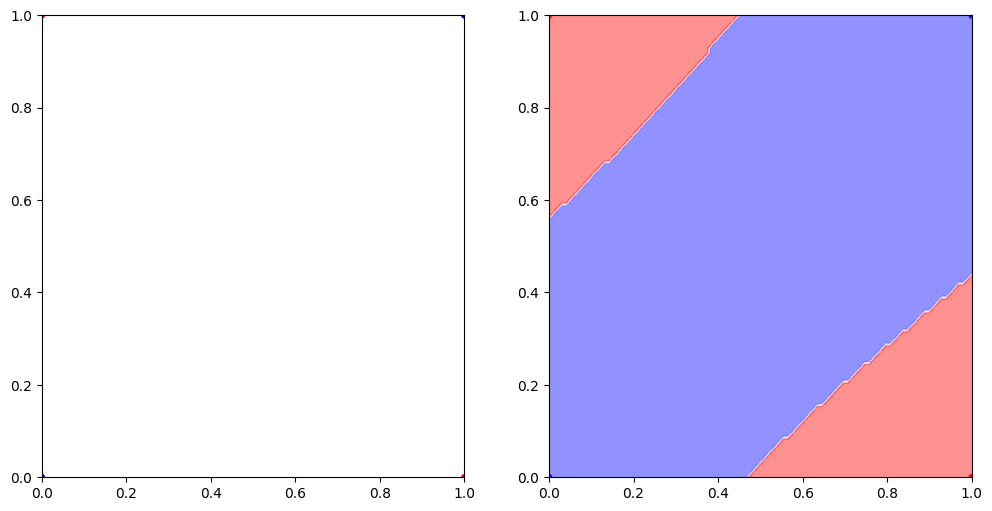

In [56]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(binary_cross_entropy, learning_rate=1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, 1000,100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


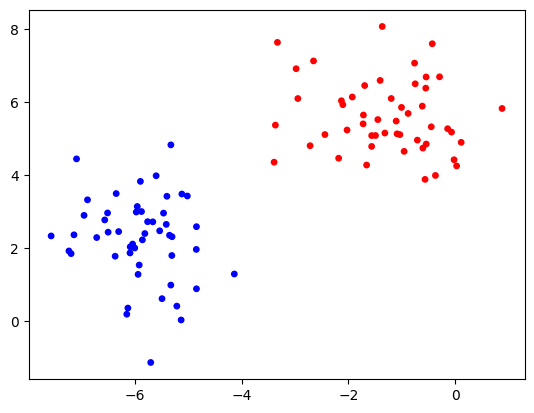

In [57]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/5000 loss_train: 3.42932876
epoch: 1000/5000 loss_train: 0.28041338
epoch: 2000/5000 loss_train: 0.11884789
epoch: 3000/5000 loss_train: 0.07860306
epoch: 4000/5000 loss_train: 0.06015686
epoch: 5000/5000 loss_train: 0.04945494
Acurácia: 100.00%


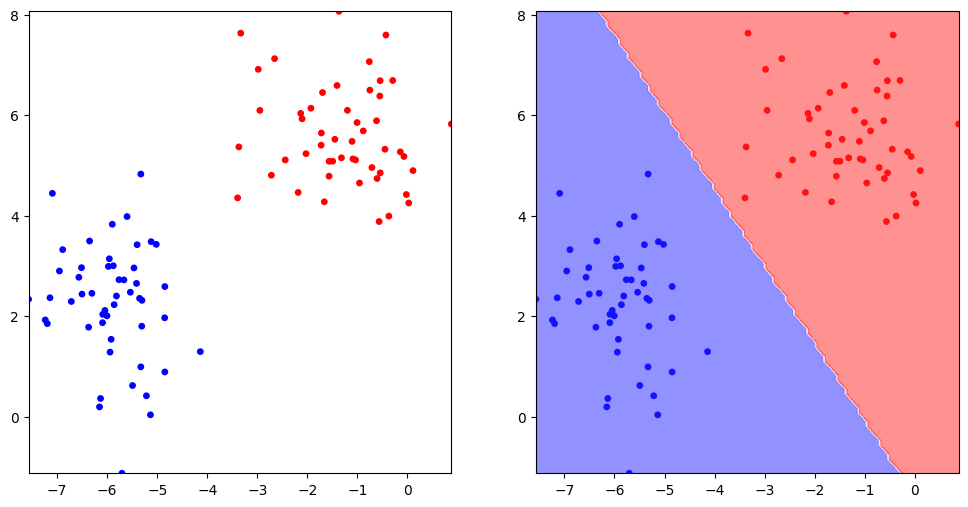

In [58]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(binary_cross_entropy, 1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, 5000,1000)

y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


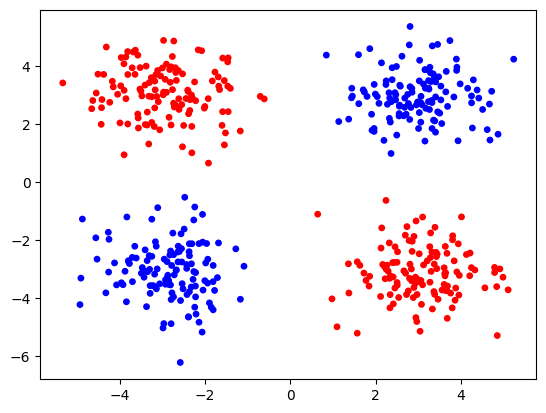

In [59]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.65081969
epoch:  100/1000 loss_train: 0.01126644
epoch:  200/1000 loss_train: 0.00645833
epoch:  300/1000 loss_train: 0.00455364
epoch:  400/1000 loss_train: 0.00350811
epoch:  500/1000 loss_train: 0.00284202
epoch:  600/1000 loss_train: 0.00237544
epoch:  700/1000 loss_train: 0.00203013
epoch:  800/1000 loss_train: 0.00176528
epoch:  900/1000 loss_train: 0.00155607
epoch: 1000/1000 loss_train: 0.00138702
Acurácia: 100.00%


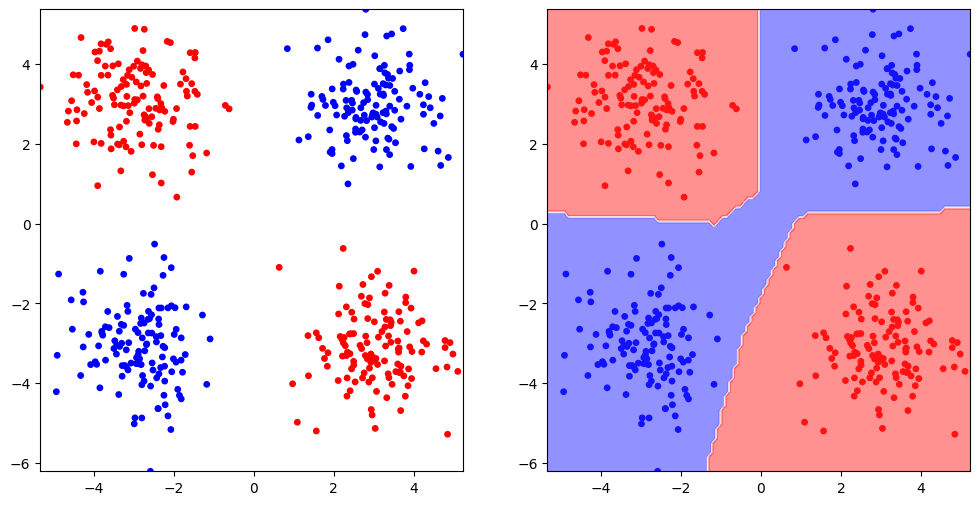

In [60]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(binary_cross_entropy, 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, 1000,100)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


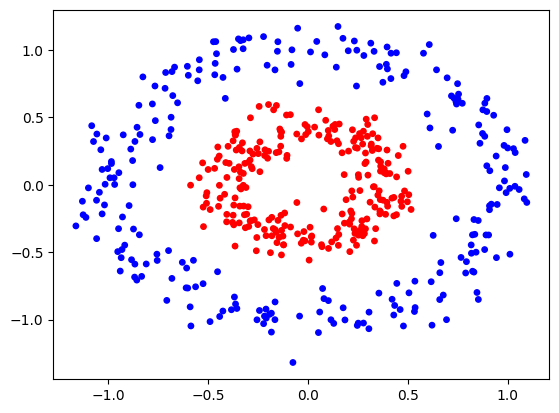

In [61]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/1000 loss_train: 0.60622935
epoch:  100/1000 loss_train: 0.44001909
epoch:  200/1000 loss_train: 0.35404665
epoch:  300/1000 loss_train: 0.22744516
epoch:  400/1000 loss_train: 0.13645460
epoch:  500/1000 loss_train: 0.10437660
epoch:  600/1000 loss_train: 0.08707020
epoch:  700/1000 loss_train: 0.07476811
epoch:  800/1000 loss_train: 0.06488756
epoch:  900/1000 loss_train: 0.05652807
epoch: 1000/1000 loss_train: 0.04959170
Acurácia: 99.60%


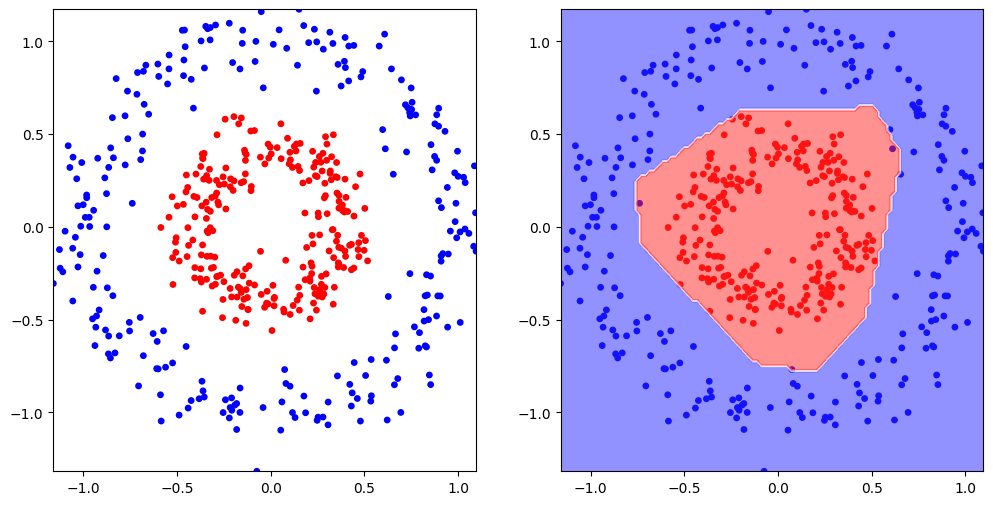

In [62]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(binary_cross_entropy, 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=output_dim, activation=sigmoid))
nn.fit(x, y, 1000,100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


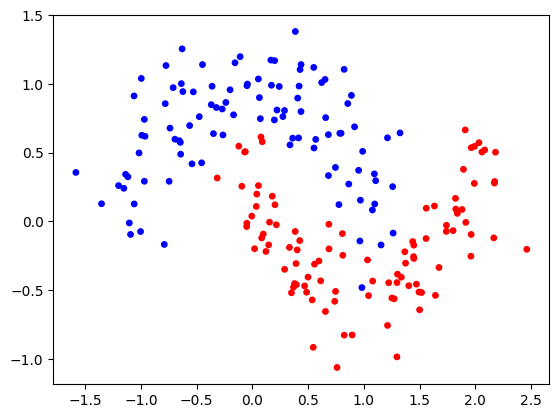

In [19]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/20000 loss_train: 1.94396661 + 0.03521656 = 1.97918317 loss_val = 1.94396661
epoch: 2000/20000 loss_train: 0.20573849 + 0.07069288 = 0.27643137 loss_val = 0.20573849
epoch: 4000/20000 loss_train: 0.14820075 + 0.10512291 = 0.25332366 loss_val = 0.14820075
epoch: 6000/20000 loss_train: 0.13648998 + 0.11012996 = 0.24661994 loss_val = 0.13648998
epoch: 8000/20000 loss_train: 0.13370591 + 0.11067683 = 0.24438275 loss_val = 0.13370591
epoch: 10000/20000 loss_train: 0.13284231 + 0.11088798 = 0.24373029 loss_val = 0.13284231
epoch: 12000/20000 loss_train: 0.13246550 + 0.11108209 = 0.24354759 loss_val = 0.13246550
epoch: 14000/20000 loss_train: 0.13225722 + 0.11123645 = 0.24349367 loss_val = 0.13225722
epoch: 16000/20000 loss_train: 0.13213516 + 0.11134021 = 0.24347537 loss_val = 0.13213516
epoch: 18000/20000 loss_train: 0.13206528 + 0.11140268 = 0.24346796 loss_val = 0.13206528
epoch: 20000/20000 loss_train: 0.13202739 + 0.11143686 = 0.24346425 loss_val = 0.13202739
Acurácia: 95.00

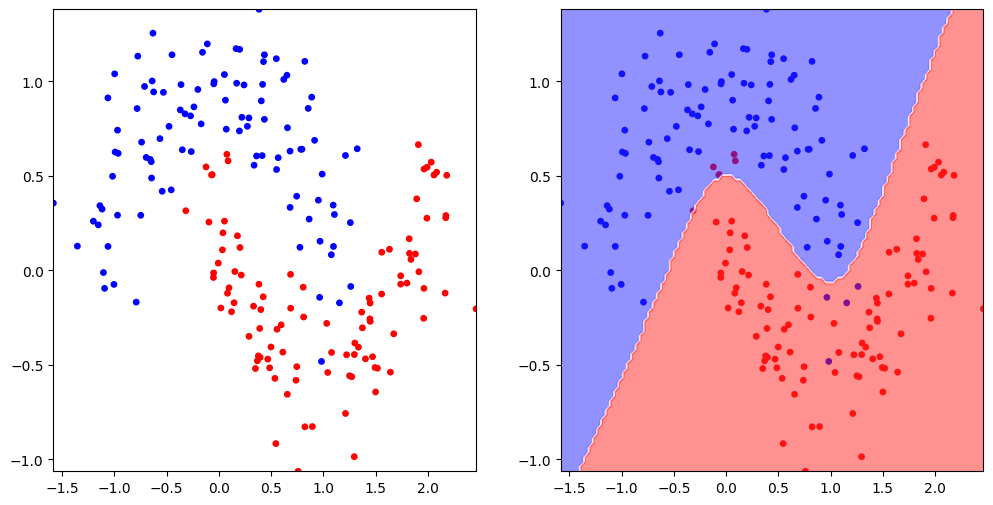

In [39]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(binary_cross_entropy, 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=8, activation=tanh, reg_strength=1, reg_func=l2_regularization))
nn.layers.append(Layer(input_dim=8, output_dim=output_dim, activation=sigmoid, reg_strength=1, reg_func=l2_regularization))
nn.fit(x, y, epochs=20000, verbose=2000)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


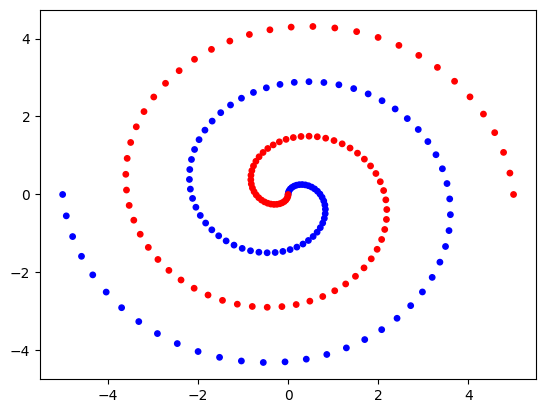

In [24]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

epoch:    0/10000 loss_train: 1.56668659 + 0.00000000 = 1.56668659 loss_val = 1.56668659
epoch: 1000/10000 loss_train: 0.69125738 + 0.00000000 = 0.69125738 loss_val = 0.69125738
epoch: 2000/10000 loss_train: 0.68868358 + 0.00000000 = 0.68868358 loss_val = 0.68868358
epoch: 3000/10000 loss_train: 0.68436725 + 0.00000000 = 0.68436725 loss_val = 0.68436725
epoch: 4000/10000 loss_train: 0.67433010 + 0.00000000 = 0.67433010 loss_val = 0.67433010
epoch: 5000/10000 loss_train: 0.66223212 + 0.00000000 = 0.66223212 loss_val = 0.66223212
epoch: 6000/10000 loss_train: 0.64559358 + 0.00000000 = 0.64559358 loss_val = 0.64559358
epoch: 7000/10000 loss_train: 0.59788252 + 0.00000000 = 0.59788252 loss_val = 0.59788252
epoch: 8000/10000 loss_train: 0.29482354 + 0.00000000 = 0.29482354 loss_val = 0.29482354
epoch: 9000/10000 loss_train: 0.13604559 + 0.00000000 = 0.13604559 loss_val = 0.13604559
epoch: 10000/10000 loss_train: 0.08128761 + 0.00000000 = 0.08128761 loss_val = 0.08128761
Acurácia: 99.50%


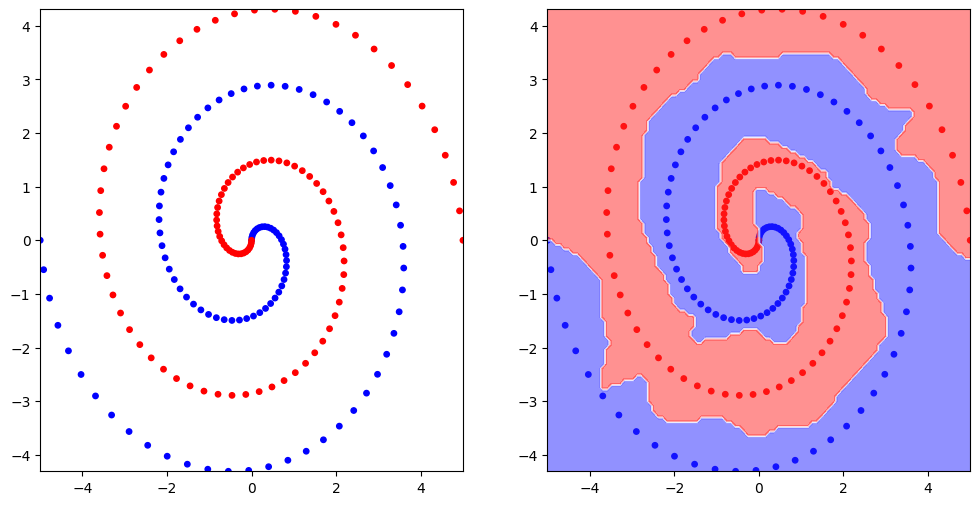

In [30]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(binary_cross_entropy, 1e-2)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh, batch_norm=True))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid, batch_norm=True))
nn.fit(x, y, epochs=10000,verbose=1000)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


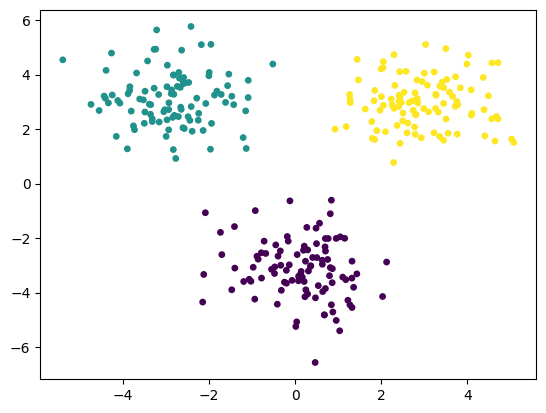

In [67]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [68]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/20000 loss_train: 7.32795396
epoch: 2000/20000 loss_train: 0.33265283
epoch: 4000/20000 loss_train: 0.22898327
epoch: 6000/20000 loss_train: 0.17185190
epoch: 8000/20000 loss_train: 0.13600357
epoch: 10000/20000 loss_train: 0.11168695
epoch: 12000/20000 loss_train: 0.09427109
epoch: 14000/20000 loss_train: 0.08128736
epoch: 16000/20000 loss_train: 0.07128511
epoch: 18000/20000 loss_train: 0.06336855
epoch: 20000/20000 loss_train: 0.05696069
Acurácia: 100.00%


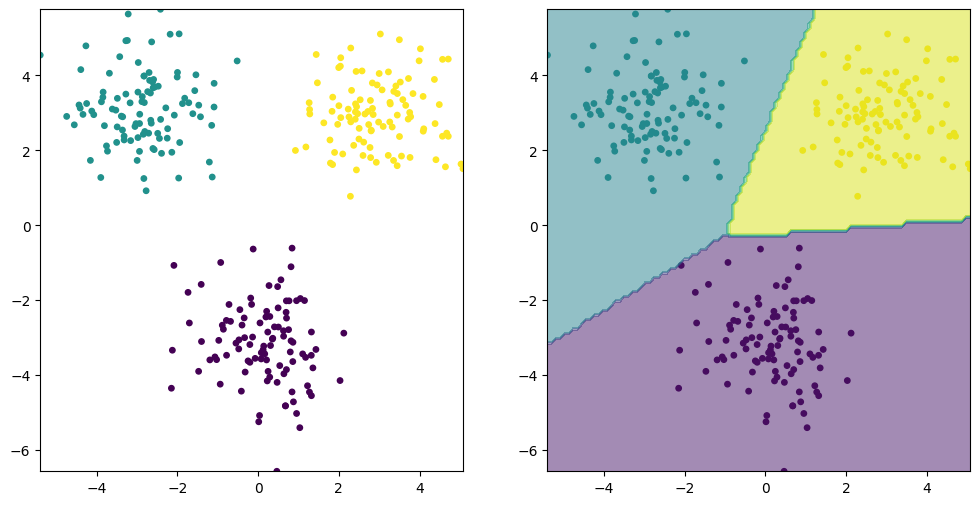

In [69]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(softmax_neg_log_likelihood, 1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, 20000,2000)
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


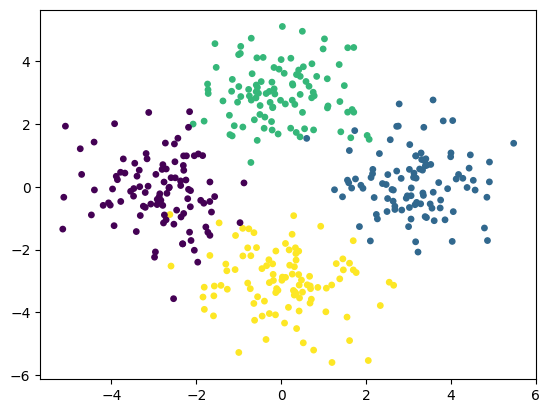

In [70]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [71]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/20000 loss_train: 13.23971731
epoch: 2000/20000 loss_train: 0.06821079
epoch: 4000/20000 loss_train: 0.06566583
epoch: 6000/20000 loss_train: 0.06390705
epoch: 8000/20000 loss_train: 0.06244479
epoch: 10000/20000 loss_train: 0.06117357
epoch: 12000/20000 loss_train: 0.05976364
epoch: 14000/20000 loss_train: 0.05833027
epoch: 16000/20000 loss_train: 0.05717171
epoch: 18000/20000 loss_train: 0.05606927
epoch: 20000/20000 loss_train: 0.05500460
Acurácia: 97.00%


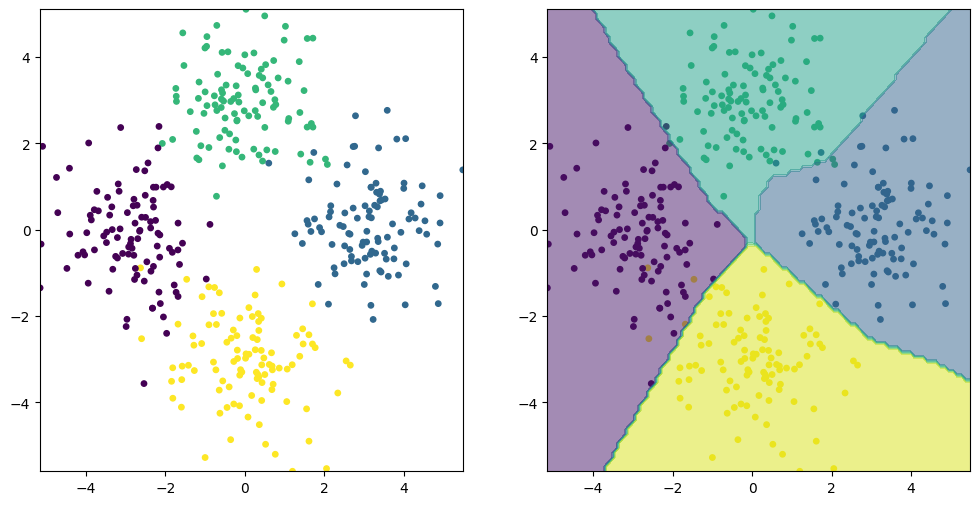

In [72]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(softmax_neg_log_likelihood, 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, 20000,2000)
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


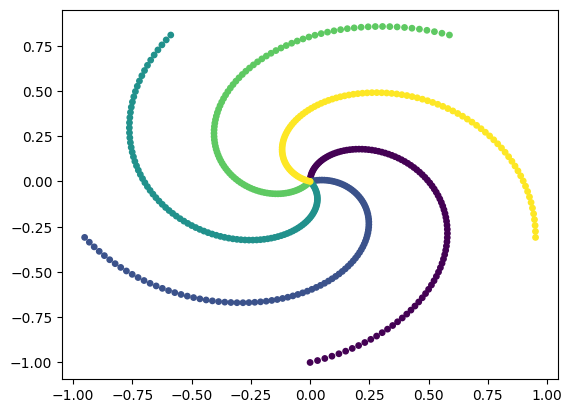

In [73]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [74]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/20000 loss_train: 2.19526543
epoch: 2000/20000 loss_train: 0.62069666
epoch: 4000/20000 loss_train: 0.31691437
epoch: 6000/20000 loss_train: 0.20822984
epoch: 8000/20000 loss_train: 0.15762336
epoch: 10000/20000 loss_train: 0.12964338
epoch: 12000/20000 loss_train: 0.11156518
epoch: 14000/20000 loss_train: 0.09882713
epoch: 16000/20000 loss_train: 0.08936840
epoch: 18000/20000 loss_train: 0.08207095
epoch: 20000/20000 loss_train: 0.07626695
Acurácia: 98.80%


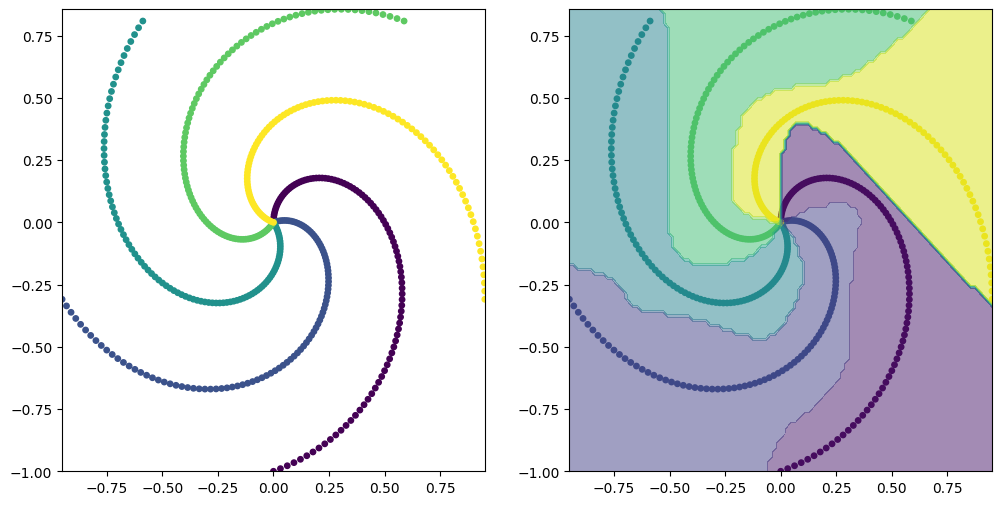

In [75]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(softmax_neg_log_likelihood, 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, 20000,2000)
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


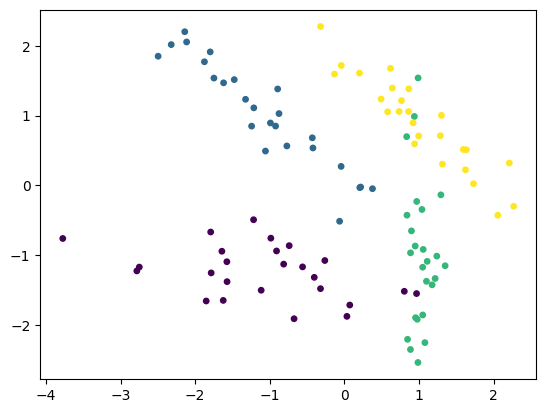

In [76]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [77]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/20000 loss_train: 1.81031508
epoch: 2000/20000 loss_train: 0.12735998
epoch: 4000/20000 loss_train: 0.10722384
epoch: 6000/20000 loss_train: 0.09369528
epoch: 8000/20000 loss_train: 0.08003875
epoch: 10000/20000 loss_train: 0.06679679
epoch: 12000/20000 loss_train: 0.05339584
epoch: 14000/20000 loss_train: 0.04371562
epoch: 16000/20000 loss_train: 0.03732380
epoch: 18000/20000 loss_train: 0.03303267
epoch: 20000/20000 loss_train: 0.02986178
Acurácia: 100.00%


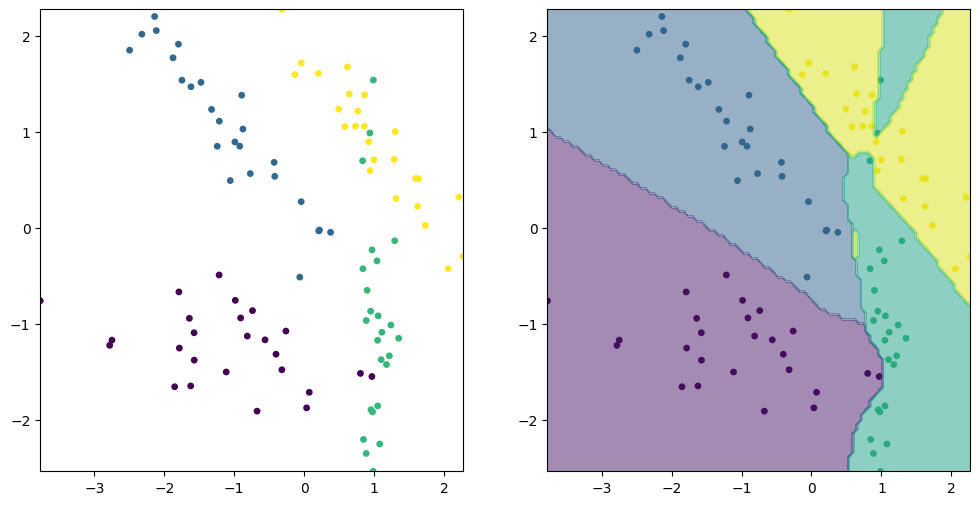

In [78]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(softmax_neg_log_likelihood, 1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, 20000,2000)
y_pred = np.argmax(nn.predict(x), axis=1)

print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


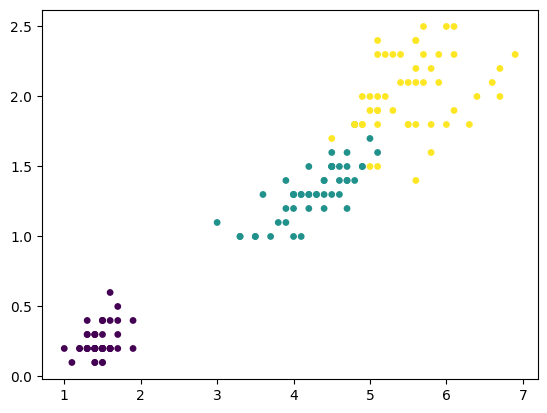

In [127]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [128]:
onehot = OneHotEncoder(sparse_output=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [39]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(softmax_neg_log_likelihood, 1e-3, lr_decay_method=exponential_decay, lr_decay_rate=0.99)
nn.layers.append(Layer(input_dim=input_dim, output_dim=25, activation=tanh))
nn.layers.append(Layer(input_dim=25, output_dim=20, activation=leaky_relu))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))
nn.fit(x, y_onehot, 100000,10000, batch_gen=batch_shuffle, batch_size=15)
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

NameError: name 'y_onehot' is not defined

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)